In [1]:
!pip install pymde emblaze gensim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 951.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 1.1 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 583.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 623.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 737.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 4.4 MB/s eta 0:00:0000:0100:09m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 9.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13

In [2]:
import pandas as pd

df = pd.read_parquet('./work/data/hiscore_updates.parquet')

# retain only rows where mode=0
df = df[df['mode'] == 0]

# retain only rows where pp>=75
df = df[df['pp'] >= 75]

# drop columns:
# - mode
# - rank
# - is_classic
df = df.drop(columns=['mode', 'rank', 'is_classic'])

# convert types:
# user -> int32
# pp -> f32
# mods -> int32
df['user'] = df['user'].astype('int32')
df['pp'] = df['pp'].astype('float32')
df['mods'] = df['mods'].astype('int32')

print(f"Retained: {len(df)}")

df.head()

Retained: 32407594


,user,beatmap_id,score,pp,mods,score_time,update_time
275,55,48067,1631540,85.583900,0,2013-03-23 03:22:26,2022-11-20 15:17:13
276,55,48067,1631540,86.331703,0,2013-03-23 11:22:26,2017-02-01 13:30:30
278,55,116876,3484018,86.219597,0,2013-05-20 13:54:29,2022-11-20 15:17:13
279,55,116876,3484018,82.921402,0,2013-05-20 21:54:29,2017-02-01 13:30:30
280,55,102891,4221594,87.754799,0,2013-05-21 13:05:41,2022-11-20 15:17:13


In [3]:
"""
We only care about the following mods:
 - DT or NC -> DT
 - HD
 - EZ
 - HR
 - HT
 - FL

And we return them as a concatenated string in alphabetical order (e.g. "DTFLHR")
"""
def decode_mods_bitset(bitset: int):
    mods = ''
    if bitset & (1 << 6):
        mods += 'DT'
    if bitset & (1 << 1):
        mods += 'EZ'
    if bitset & (1 << 10):
        mods += 'FL'
    # if bitset & (1 << 3):
    #     mods += 'HD'
    if bitset & (1 << 4):
        mods += 'HR'
    if bitset & (1 << 8):
        mods += 'HT'

    return mods

# Apply the function to the 'mods' column
df['mods'] = df['mods'].apply(decode_mods_bitset)

In [4]:
df['score_id'] = df['beatmap_id'].astype(str) + '_' + df['mods'].astype(str)

In [5]:
# pre-sort the hiscores df by (user ascending, score_id ascending, update_time descending)
df.sort_values(by=['user', 'score_id', 'update_time'], ascending=[True, True, False], inplace=True)

# retain only the top pp score for each user+score_id
df = df.drop_duplicates(subset=['user', 'score_id'], keep='first')

In [6]:
user_counts = df.groupby('score_id')['user'].nunique()
user_counts.head()

score_id
1000052_DTHR     3
1000075_         3
1000075_DT       1
1000168_        63
1000168_HR       3
Name: user, dtype: int64

In [7]:
# find all unique score IDs by user id=4093752 and dump to csv
user_scores = df[df['user'] == 4093752]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/my_score_ids.csv', index=False)

# same for 3637436
user_scores = df[df['user'] == 3637436]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/blankz_score_ids.csv', index=False)

# same for 35452149
user_scores = df[df['user'] == 35452149]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/big_tomas_score_ids.csv', index=False)

# same for 32290754
user_scores = df[df['user'] == 32290754]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/peblohh_score_ids.csv', index=False)

In [8]:
# dump some extra metadata about scores to csv:
#
# - score_id
# - average pp
# - number of unique users

score_metadata = df.groupby('score_id').agg(
    avg_pp=('pp', 'mean'),
    num_users=('user', 'nunique')
).reset_index()

score_metadata.to_csv('./work/data/score_metadata.csv', index=False)

# create dict for local use
avg_pp_by_score_id = score_metadata.set_index('score_id')['avg_pp'].to_dict()

In [9]:
# Count how many 'score_id' have exactly one unique user
single_user_score_ids = user_counts[user_counts == 1].count()

print(f"Number of 'score_id' with exactly one unique user: {single_user_score_ids}")

two_user_score_ids = user_counts[user_counts == 2].count()

print(f"Number of 'score_id' with exactly two unique users: {two_user_score_ids}")

three_user_score_ids = user_counts[user_counts == 3].count()

print(f"Number of 'score_id' with exactly three unique users: {three_user_score_ids}")

four_user_score_ids = user_counts[user_counts == 4].count()

print(f"Number of 'score_id' with exactly four unique users: {four_user_score_ids}")

# filter out scores with low user counts
#
# there are way fewer very high pp plays (>500) than there are low pp plays, so we want
# to be more strict when deciding whether to filter low pp plays
#
# Filter out scores with less than 50 unique users at pp=100 and below, and linearly scale
# the filter threshold down to 5 users at pp=500.
def should_retain(score_id):
    avg_pp = avg_pp_by_score_id[score_id]
    num_users = user_counts[score_id]

    edge0 = 100
    edge1 = 500
    activation = max(0, min(1, (avg_pp - edge0) / (edge1 - edge0)))
    # scale from [0, 1] to [50, 5]
    threshold = 50 - (50 - 5) * activation

    return num_users >= threshold

before_score_count = len(df)
# df = df[df['score_id'].isin(user_counts[user_counts >= 50].index)]
df = df[df['score_id'].apply(should_retain)]

print(f'Filtered scores from {before_score_count} -> {len(df)}')

Number of 'score_id' with exactly one unique user: 46147
Number of 'score_id' with exactly two unique users: 18333
Number of 'score_id' with exactly three unique users: 10865
Number of 'score_id' with exactly four unique users: 7441
Filtered scores from 27194034 -> 26400468


In [10]:
unique_scores = df['score_id'].unique()

# populate mapping from score id to index in the co-occurrence matrix
score_to_index = {score: i for i, score in enumerate(unique_scores)}

df['score_ix'] = df['score_id'].apply(lambda x: score_to_index[x]).astype('int32')

print(f"Unique score count: {len(unique_scores)}")

Unique score count: 34167


In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from numba import jit
import gc

def condense_matrices(main_csr, uniq_score_count, rows, cols, vals):
    coo = coo_matrix((vals, (rows, cols)), shape=(uniq_score_count, uniq_score_count), dtype=np.float32)
    main_csr += coo.tocsr()

    gc.collect()

    return main_csr

chunk_size = 100_000_000

@jit(nopython=True)
def fill_arrays(cur_scores: np.ndarray, cur_scores_pps: np.ndarray, cur_score_ix: int, rows: np.ndarray, cols: np.ndarray, vals: np.ndarray, arr_ix: int) -> int:
    for i in range(cur_score_ix - 1):
        score_i_ix = cur_scores[i]

        for j in range(i + 1, cur_score_ix):
            # compute weight based on relative pp difference
            #
            # 0% difference -> weight = 2
            # 25% difference -> weight = 1
            # 50% difference -> weight = 0
            # >50% difference -> weight = 0
            #
            # decreasing linearly from 1 to 0 as difference increases.  Anything over 50% difference is 0.
            pp_i = cur_scores_pps[i]
            pp_j = cur_scores_pps[j]
            max_pp = max(pp_i, pp_j)
            relative_diff = abs(pp_i - pp_j) / max_pp
            weight = 0 if relative_diff > 0.5 else (1 - (relative_diff / 0.5)) * 2

            if weight <= 0:
                continue

            score_j_ix = cur_scores[j]
            rows[arr_ix] = score_i_ix
            cols[arr_ix] = score_j_ix
            vals[arr_ix] = weight
            arr_ix += 1

            if arr_ix >= chunk_size:
                raise ValueError("Array index out of bounds")

    return arr_ix

def compute_cooccurrence_matrix(uniq_score_count: int, df: pd.DataFrame) -> csr_matrix:
    main_csr = csr_matrix((uniq_score_count, uniq_score_count), dtype=np.float32)

    # collect up chunks of matrix entries
    rows = np.ndarray(chunk_size, dtype=np.int32)
    cols = np.ndarray(chunk_size, dtype=np.int32)
    vals = np.ndarray(chunk_size, dtype=np.float32)
    arr_ix = 0

    cur_user_id = 0
    # re-use typed array for current user's scores
    cur_scores = np.ndarray(50000, dtype=np.int32)
    cur_scores_pps = np.ndarray(50000, dtype=np.float32)
    cur_score_ix = 0

    row_ix = 0
    for row in df.itertuples():
        if row_ix % 2000000 == 0:
            print(f"Processing row {row_ix} of {len(df)}")
            main_csr.sum_duplicates()
            print(f"Main CSR nnz: {main_csr.nnz}")

        user_id = row.user
        score_ix = row.score_ix
        pp = row.pp

        if cur_user_id != user_id:
            needed_space = (cur_score_ix * (cur_score_ix - 1)) // 2
            if needed_space + arr_ix >= chunk_size:
                main_csr = condense_matrices(main_csr, uniq_score_count, rows[:arr_ix], cols[:arr_ix], vals[:arr_ix])
                arr_ix = 0

            arr_ix = fill_arrays(cur_scores, cur_scores_pps, cur_score_ix, rows, cols, vals, arr_ix)

            cur_user_id = user_id
            cur_scores[0] = score_ix
            cur_scores_pps[0] = pp
            cur_score_ix = 1
        else:
            cur_scores[cur_score_ix] = score_ix
            cur_scores_pps[cur_score_ix] = pp
            cur_score_ix += 1

        row_ix += 1

    print(f"final main CSR nnz: {main_csr.nnz}")

    return main_csr

In [12]:
cooccurrence_matrix = compute_cooccurrence_matrix(len(unique_scores), df)

Processing row 0 of 26400468
Main CSR nnz: 0
Processing row 2000000 of 26400468
Main CSR nnz: 28987398
Processing row 4000000 of 26400468
Main CSR nnz: 59628269
Processing row 6000000 of 26400468
Main CSR nnz: 72637340
Processing row 8000000 of 26400468
Main CSR nnz: 83651910
Processing row 10000000 of 26400468
Main CSR nnz: 93277615
Processing row 12000000 of 26400468
Main CSR nnz: 106434015
Processing row 14000000 of 26400468
Main CSR nnz: 114323458
Processing row 16000000 of 26400468
Main CSR nnz: 122228979
Processing row 18000000 of 26400468
Main CSR nnz: 130499703
Processing row 20000000 of 26400468
Main CSR nnz: 138832789
Processing row 22000000 of 26400468
Main CSR nnz: 146862273
Processing row 24000000 of 26400468
Main CSR nnz: 153765901
Processing row 26000000 of 26400468
Main CSR nnz: 157107473
final main CSR nnz: 157107473


In [13]:
# symmetrize
sym_cooccurrence_matrix = (cooccurrence_matrix + cooccurrence_matrix.transpose()).tocsr()
print(f"Symmetrized co-occurrence matrix nnz: {sym_cooccurrence_matrix.nnz}")

Symmetrized co-occurrence matrix nnz: 314214946


In [14]:
# Now, we want to sparsify the matrix further by retaining only the top n co-occurrences for each score_id
#
# Since we've already symmetrized the matrix, we can just iterate over the rows, retain the top n co-occurrences,
# and build a new sparse matrix from that.  We also trim out any low-count co-occurrences.
#
# While we're at it, we also need to map the values from co-occurrence counts to a distance metric such that
# higher counts are closer to 0. We'll use the following formula:
#
# distance = 1 / log(count)

rows, cols, data = [], [], []

topn = 700
for row_ix in range(sym_cooccurrence_matrix.shape[0]):
    if row_ix % 1000 == 0:
        print(f"Processing row {row_ix} of {sym_cooccurrence_matrix.shape[0]}")

    row = sym_cooccurrence_matrix.getrow(row_ix)
    top_indices = np.argsort(row.data)[-topn:]
    # filter out low-count co-occurrences
    top_indices = top_indices[row.data[top_indices] > 2]
    rows.extend([row_ix] * len(top_indices))
    cols.extend(row.indices[top_indices])
    # mapped_data = -np.log(row.data[top_indices] / row.data.sum())
    mapped_data = np.reciprocal(np.log(row.data[top_indices]))
    data.extend(mapped_data)
    # data.extend(row.data[top_indices])
    # data.extend(np.ones(len(top_indices), dtype=np.float32))

top_cooccurrence_matrix = csr_matrix((data, (rows, cols)), shape=sym_cooccurrence_matrix.shape, dtype=np.float32)
print(f"Top co-occurrence matrix nnz: {top_cooccurrence_matrix.nnz}")

Processing row 0 of 34167
Processing row 1000 of 34167
Processing row 2000 of 34167
Processing row 3000 of 34167
Processing row 4000 of 34167
Processing row 5000 of 34167
Processing row 6000 of 34167
Processing row 7000 of 34167
Processing row 8000 of 34167
Processing row 9000 of 34167
Processing row 10000 of 34167
Processing row 11000 of 34167
Processing row 12000 of 34167
Processing row 13000 of 34167
Processing row 14000 of 34167
Processing row 15000 of 34167
Processing row 16000 of 34167
Processing row 17000 of 34167
Processing row 18000 of 34167
Processing row 19000 of 34167
Processing row 20000 of 34167
Processing row 21000 of 34167
Processing row 22000 of 34167
Processing row 23000 of 34167
Processing row 24000 of 34167
Processing row 25000 of 34167
Processing row 26000 of 34167
Processing row 27000 of 34167
Processing row 28000 of 34167
Processing row 29000 of 34167
Processing row 30000 of 34167
Processing row 31000 of 34167
Processing row 32000 of 34167
Processing row 33000 of

In [15]:
import pymde

import numpy as np
import matplotlib.pyplot as plt

cooccurrence_graph = pymde.preprocess.Graph(top_cooccurrence_matrix)

In [21]:
n_neighbors = 10
embedding_dim = 3

mde = pymde.preserve_neighbors(
    cooccurrence_graph,
    # shortest_path_graph,
    embedding_dim=embedding_dim,
    attractive_penalty=pymde.penalties.Linear,
    # repulsive_penalty=None,
    verbose=True,
    # max_distance=1.2,
    n_neighbors=n_neighbors,
    init="random",
    # device='cuda'
)

Jul 02 09:13:54 PM: Computing 10-nearest neighbors, with max_distance=1.2368264198303223
Jul 02 09:13:54 PM: Computing shortest path distances (retaining 100.00 percent with max_distance=1.2368264198303223) ...
Jul 02 09:13:54 PM: Graph is weighted ... using slow path.
Jul 02 09:14:03 PM: processed node 1/34167
Jul 02 09:15:11 PM: processed node 3417/34167
Jul 02 09:16:18 PM: processed node 6833/34167
Jul 02 09:17:24 PM: processed node 10249/34167
Jul 02 09:18:31 PM: processed node 13665/34167
Jul 02 09:19:38 PM: processed node 17081/34167
Jul 02 09:20:45 PM: processed node 20497/34167
Jul 02 09:21:52 PM: processed node 23913/34167
Jul 02 09:22:58 PM: processed node 27329/34167
Jul 02 09:24:04 PM: processed node 30745/34167
Jul 02 09:25:08 PM: processed node 34161/34167


In [ ]:
# mde.constraint = pymde.constraints.Standardized()
# mde.distortion_function.attractive_penalty = pymde.penalties.Log1p(mde.distortion_function.attractive_penalty.weights)

In [22]:
embedding = mde.embed(verbose=True, max_iter=2000, print_every=50)

Jul 02 09:25:40 PM: Fitting a centered embedding into R^3, for a graph with 34167 items and 670655 edges.
Jul 02 09:25:40 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Jul 02 09:25:40 PM: iteration 0000 | distortion 1.237086 | residual norm 0.0117296 | step length 550.5 | percent change 2.01218
Jul 02 09:25:42 PM: iteration 0050 | distortion 0.545336 | residual norm 0.00264777 | step length 1 | percent change 1.94063
Jul 02 09:25:43 PM: iteration 0100 | distortion 0.397887 | residual norm 0.00292509 | step length 1 | percent change 5.33791
Jul 02 09:25:45 PM: iteration 0150 | distortion 0.328965 | residual norm 0.00157828 | step length 1 | percent change 0.596695
Jul 02 09:25:46 PM: iteration 0200 | distortion 0.312411 | residual norm 0.00118046 | step length 1 | percent change 0.532478
Jul 02 09:25:48 PM: iteration 0250 | distortion 0.303682 | residual norm 0.00114307 | step length 1 | percent change 0.477224
Jul 02 09:25:49 PM: iteration 0300 | distortion 

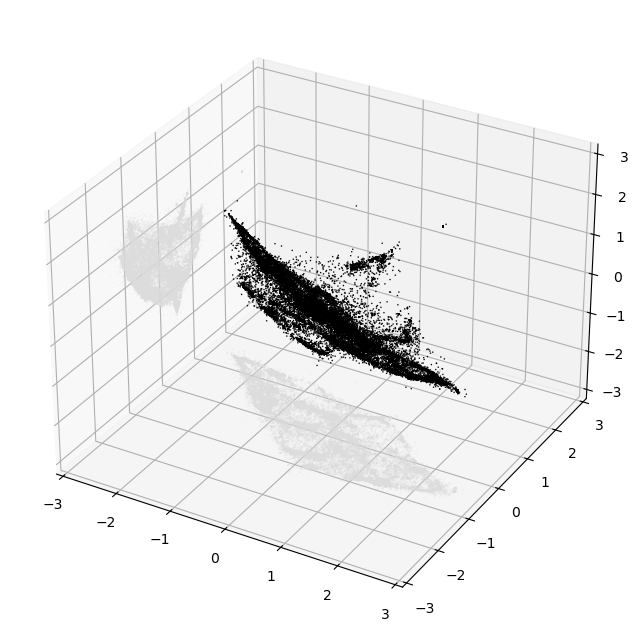

In [23]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [24]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n_bigger.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(embedding), mde.embedding_dim))
    for i in range(len(embedding)):
        row = embedding[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_3d_10n_bigger.w2v'

In [25]:
# write dataframe mapping score_id to index
mapping = [(score_id, i) for score_id, i in score_to_index.items()]
mapping_df = pd.DataFrame(mapping, columns=['score_id', 'index'])
mapping_df.to_csv(f'{fname}.csv', index=False)
mapping_df.head()

# code to load:
# mapping_df = pd.read_csv('./work/data/score_id_mapping.csv')
# score_id_by_ix = mapping_df.set_index('index')['score_id'].to_dict()

,score_id,index
0,1007525_,0
1,1057659_,1
2,1089041_,2
3,109479_,3
4,112583_,4
